In [1]:
import os
import copy
import pickle
import numpy as np
import glob

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# astropy
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.coordinates import SkyCoord, Angle
from astropy import wcs
from astropy.table import Table,vstack
import astropy.units as u
import matplotlib.pyplot as plt 


import sys
# so can find module one dir back; don't need to explicitly put .py into each subfolder 
sys.path.append("..")
from candels_galaxy_surveys import galaxy_catalog,galaxy_survey
import update_galaxy_survey

# so can find script for host ellipses 
sys.path.append("../visualize_hosts/")
from sn_cutout import ellipse

In [2]:
# these candels SNs are the ones  I have host matches for
candels_Ias = pickle.load(open('host_data/candels_Ias.pkl','rb'))
candels_CCs = pickle.load(open('host_data/candels_CCs.pkl','rb'))
candels_SNs = pickle.load(open('host_data/candels_SNs.pkl','rb'))

# want to look at all these SN in some value like (zHost-zSN)/(sigma_z)
# where sigma_z is combined error  of host & SN 
# sigma_z ~ sqrt(dzSN^2 + dzHost^2)
# if host good spectrum should I still use the l68, u68 errors based on the photo-z uncertainties?
# same for SN?
# at the moment I'm going to pretend those errors apply regardless of good/bad spectrums

# putting them all back together into a single list
candels = candels_Ias + candels_CCs + candels_SNs
nearbys = []
hosts = []

"""
# The goods SN don't have host matches 
# including them so don't forget about them
goods_Ias = pickle.load(open('host_data/goods_Ias.pkl','rb'))
goods_CCs = pickle.load(open('host_data/goods_CCs.pkl','rb'))

# putting these back together in single list
goods = goods_Ias + goods_CCs
"""

"\n# The goods SN don't have host matches \n# including them so don't forget about them\ngoods_Ias = pickle.load(open('host_data/goods_Ias.pkl','rb'))\ngoods_CCs = pickle.load(open('host_data/goods_CCs.pkl','rb'))\n\n# putting these back together in single list\ngoods = goods_Ias + goods_CCs\n"

In [3]:
# Making sure  the surveys  are most up to date 

for i in range(len(candels_Ias)):
    nearbys.append(update_galaxy_survey.update_survey(candels_Ias[i][1]))
for i in range(len(candels_CCs)):
    nearbys.append(update_galaxy_survey.update_survey(candels_CCs[i][1]))
for i in range(len(candels_SNs)):
    nearbys.append(update_galaxy_survey.update_survey(candels_SNs[i][1]))

for i in range(len(candels_Ias)):
    hosts.append([update_galaxy_survey.update_survey(candels_Ias[i][2][0]),candels_Ias[i][2][1],candels_Ias[i][2][2]])
for i in range(len(candels_CCs)):
    hosts.append([update_galaxy_survey.update_survey(candels_CCs[i][2][0]),candels_CCs[i][2][1],candels_CCs[i][2][2]])
for i in range(len(candels_SNs)):
    hosts.append([update_galaxy_survey.update_survey(candels_SNs[i][2][0]),candels_SNs[i][2][1],candels_SNs[i][2][2]])

In [4]:
# parameter delz to help judge which SN need to be looked at from my nearest hosts catalog
#  delz is (znearest - zsn)/sigz ... sigz error in quad of both host and SN
# will make evernote page for each SN organized by these delzs and say if delz > 2 will provide explanation 

delzs = []
for i in range(len(candels)):
    # the SN
    
    # the composite SN best redshift reported; weighted from all avail phot,spec,host info 
    zSN = np.float(candels[i][0]['zSN'])
    dzSN = np.float(candels[i][0]['dzSN'])
    
    
    # the host (nearest from my catalog)
    
    # good spectrum z if avail, otherwise most likely photo z if spectrum not good or n/a
    zHost = np.float(hosts[i][0].mass[hosts[i][0].redshift_names])
    
    # goods-n extra z info is not in same catalog table as the other fields
    # need this annoying if statement    
    if hosts[i][0].source == 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':

        zspecHost = np.float(hosts[i][0].physpar[hosts[i][0].zspec])
        zphotHost = np.float(hosts[i][0].physpar[hosts[i][0].zphot])

        # the photometric lower and upper bounds for redshift 1sig from most likely photo z 
        zl68 = np.float(hosts[i][0].physpar[hosts[i][0].dz_l68])
        zu68 = np.float(hosts[i][0].physpar[hosts[i][0].dz_u68])

        # I am just going to say a 'dz' for the host is (u68-l68)/2 not worry about skew at the moment
        dzHost = (zu68-zl68)/2

    else:

        zspecHost = np.float(hosts[i][0].mass[hosts[i][0].zspec])
        zphotHost = np.float(hosts[i][0].mass[hosts[i][0].zphot])

        # the photometric lower and upper bounds for redshift 1sig from most likely photo z 
        zl68 = np.float(hosts[i][0].mass[hosts[i][0].dz_l68])
        zu68 = np.float(hosts[i][0].mass[hosts[i][0].dz_u68])

        # I am just going to say a 'dz' for the host is (u68-l68)/2 not worry about skew at the moment
        dzHost = (zu68-zl68)/2
        
    
    """
    #  do I report an error on host redshift if have good spectrum?
    # the l68, u68 are for the photo-z and may not even contain the spec z reported
    if zspecHost == zHost: # had  a good spectrum on the host that is redshift reported
        dzHost = 0
    """
    
    # SN - Host disagreement using best avail redshifts for each
    dz = (zSN-zHost)
    # the combined host and SN errors
    sigz = np.sqrt(dzHost**2 + dzSN**2)
    #  parameter to see quality of SN and Host redshift agreement
    delz = dz/sigz
    
    delzs.append(delz)
    
    
    

Text(0.5, 0.98, '(Nearest - SN)/sigz')

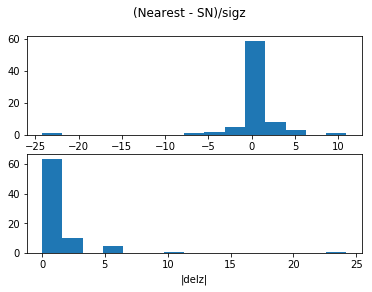

In [5]:
fig, (ax0,ax1) = plt.subplots(2,1)

ax0.hist(delzs,bins=15)
ax0.set_xlabel('delz')

ax1.hist(np.abs(delzs),bins=15)
ax1.set_xlabel('|delz|')

fig.suptitle('(Nearest - SN)/sigz')

In [6]:
delzs

[-0.002608597030331647,
 0.7165671503617139,
 0.5428017577483051,
 0.48447993991778554,
 0.14166174794136652,
 -0.6071717502046486,
 1.295032704978426,
 -1.4905682257068895,
 0.2787683961148091,
 1.7711158240373919,
 -0.44779885810340164,
 10.940044070023767,
 -1.787360367925422,
 0.01571268246113501,
 4.933951021143716,
 0.0,
 0.0,
 0.7058335080217003,
 -1.1269782606598981,
 -0.04934497346113049,
 2.12845240445465,
 0.48566473061690446,
 0.1789374552632234,
 0.551998037343801,
 0.3714117277412209,
 5.279406254256586,
 -0.5665674860208286,
 2.9058767688033744,
 1.1289265769249532,
 -1.0988640344631018,
 1.407475809943065,
 1.3659245417064485,
 -5.793050568123312,
 -24.222807748960488,
 -0.02739469005394969,
 -3.171070146583609,
 0.5754934061746111,
 0.04078236951430937,
 -0.17942820554785574,
 0.0,
 -1.4513630455485975,
 -4.9834994153003,
 -0.14804664203952106,
 0.027268220501272464,
 0.0,
 -0.022216737285146917,
 1.3702489294934417,
 -0.6427915552282569,
 0.023330093267591796,
 0.9780

In [7]:
# connect the 'delz' parameter to the candels SN 
merged = list(zip(delzs,candels))

In [24]:
# sorting the SN by the largest disagreements ie by the delz values
s = sorted(merged, key = lambda x: (np.abs(x[0])))

In [30]:
# will use this in candels folder making nb for each SN 
pickle.dump(s,open('candels/delz_candels.pkl','wb'))